In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import atan, pi, sqrt

import scipy
from PIL import Image
from skimage import io
from skimage.segmentation import quickshift
from skimage.segmentation import mark_boundaries, find_boundaries
from skimage.util import img_as_float
import random
from IPython.display import clear_output
import sklearn

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay


In [2]:
def summary_statistics(segment_pixels):
    """
    For each band, compute: min, max, mean, variance, skewness, kurtosis
    """
    features = []
    n_pixels = segment_pixels.shape
    stats = scipy.stats.describe(segment_pixels)
    band_stats = list(stats)
    if n_pixels == 1:
        # scipy.stats.describe raises a Warning and sets variance to nan
        band_stats[3] = 0.0  # Replace nan with something (zero)
    features += band_stats
    return features


def segment_quickshift(img, ratio=0.85, sigma=0, save_plot=False):
    image = io.imread(img)
    image = img_as_float(image)

    segments = quickshift(image, ratio=ratio, sigma=sigma)
    
    
    if save_plot:
        fig = plt.figure("Quickshift segmentation")
        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(mark_boundaries(image, segments))
        plt.axis("off")
        plt.savefig('segments_quickshift.png', dpi=300)
    return segments


def create_superpixels(img):
    """
    Creates objects based on a given segmentation algorithm
    """
    image = io.imread(img)
    image = img_as_float(image)
    segments = segment_quickshift(img)
    segment_ids = np.unique(segments)
    superpixels = []
    for segment_id in segment_ids:
        segment_pixels = image[segments == segment_id]
        segment_stats = summary_statistics(segment_pixels)
        superpixels.append(
            {
                'id': segment_id,
                'stats': segment_stats,
                'pixels': segment_pixels.shape
            }
        )
    return superpixels


# todo: The idea is to first create the equal area hemispherical projection. Then, given the image,
#  perform SLIC segmentation. Then, using an existing training database (created using all ANP images),
#  classify segments using a deep neural network (or random forests, or MLP, or SVM).

def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=10.0, threshold=0.1):
    """
    Return a sharpened version of the image, using an unsharp mask.
    """
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened


def create_hemispherical(image_path):
    """
    Creates an equal-area hemispherical image from a 360 image.
    :param image_path: path to 360 image.
    :return:
    """
    try:
        img = cv2.imread(image_path)
    except Exception as e:
        raise Exception(f'Could not import image. Original exception: {e}')
    dim1 = img.shape[0]
    img_h1 = np.zeros((dim1 + 1, dim1 + 1, 3))
    img_h2 = img_h1.copy()
    dim2 = int(dim1 / 2)

    for i in range(-dim2, dim2):
        for j in range(-dim2, dim2):
            if i >= 0:
                ix = dim1
            elif j >= 0:
                ix = dim1 * 2
            else:
                ix = 0
            if i == 0:
                if j < 0:
                    ix = round(dim1/-2) + ix
                elif j > 0:
                    ix = round(dim1/2) + ix
                else:
                    continue
            else:
                ix = round(atan(j / i) * dim1 / pi) + ix
            iy = sqrt(i ** 2 + j ** 2)
            iy2 = round(dim2 * np.arcsin(iy / dim2 / np.sqrt(2)) / pi * 4)
            if 1 <= ix <= dim1 * 2 and 1 <= iy2 <= dim1 // 2:
                img_h2[i + dim2, j + dim2] = img[iy2, ix-1]

    im_b = np.concatenate((img_h2[:dim2], img_h2[dim2 + 2:]), axis=0)
    im_bb = np.concatenate((im_b[:, :dim2], im_b[:, dim2 + 2:]), axis=1)

    im = Image.fromarray(im_bb.astype(np.uint8))
    image_name = image_path.split('.')[0]
    im.save(image_name + "_area.png")
    
    return im_bb

In [4]:
class SkyView:
    def __init__(
        self,
        image_path: str
        ):
        pass
    
    

In [5]:
# image = "R0013229.JPG"
image = "R0012437.JPG"
create_hemispherical(image)
image_name = image.split('.')[0] + "_area.png"

superpixels = create_superpixels(image_name)

/tmp/ipykernel_86363/2652255166.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stats = scipy.stats.describe(segment_pixels)
/home/iosefa/repos/tropforTools/venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1522: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(a, axis, bias=bias)
/home/iosefa/repos/tropforTools/venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(a, axis, bias=bias)


In [6]:
segments = segment_quickshift(image_name)

In [7]:
def flatten(aList):
    t = []
    for i in aList:
        if not isinstance(i, (np.ndarray, tuple)):
             t.append(i)
        else:
             t.extend(flatten(i))
    return t

In [15]:
df = pd.DataFrame(columns = ['segment_id', 'nobs', 'b1_min', 'b1_max', 'b2_min', 'b2_max', 'b3_min', 'b3_max', 'b1_mean', 'b2_mean',
 'b3_mean', 'b1_variance', 'b2_variance', 'b3_variance', 'b1_skewness', 'b2_skewness',
 'b3_skewness', 'b1_kurtosis', 'b2_kurtosis', 'b3_kurtosis']
)

for i, superpixel in enumerate(superpixels):
    row = flatten(superpixel['stats'])
    df.loc[i] = [i] + row

In [17]:
df_clean = df.dropna()
df.head()

,segment_id,nobs,b1_min,b1_max,b2_min,b2_max,b3_min,b3_max,b1_mean,b2_mean,b3_mean,b1_variance,b2_variance,b3_variance,b1_skewness,b2_skewness,b3_skewness,b1_kurtosis,b2_kurtosis,b3_kurtosis
0,0.0,583.0,0.0,0.043137,0.031373,0.121569,0.164706,0.152941,0.029778,0.069008,0.056732,0.000361,0.000443,0.000425,1.206844,1.248196,1.256457,1.757261,1.610528,1.707746
1,1.0,787.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,155.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,289.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,340.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


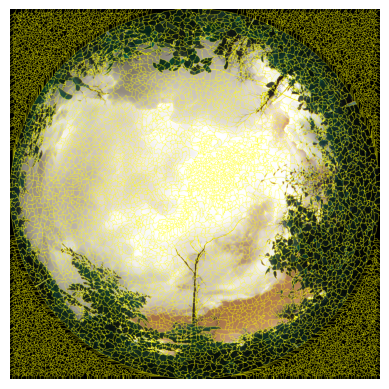

In [9]:
img = io.imread(image_name)
img = img_as_float(img)
segments.shape

fig = plt.figure("Quickshift segmentation")
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(img, segments))
plt.axis("off")
plt.savefig(f'{image_name}_segments.png', dpi=300)

In [27]:
segment_classes = pd.DataFrame(columns = ['class', 'nobs', 'b1_min', 'b1_max', 'b2_min', 'b2_max', 'b3_min', 'b3_max', 'b1_mean', 'b2_mean',
 'b3_mean', 'b1_variance', 'b2_variance', 'b3_variance', 'b1_skewness', 'b2_skewness',
 'b3_skewness', 'b1_kurtosis', 'b2_kurtosis', 'b3_kurtosis']
)


working on segment 5903.0 (499/500)


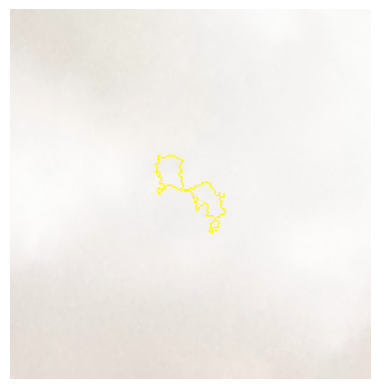

Enter class or type 'end' to end.1


In [44]:
sample = random.sample(list(df_clean['segment_id'].values), 500)

for j, i in enumerate(sample):
    print(f'working on segment {i} ({j}/500)')
    mask = np.ma.masked_where(segments !=i, segments)
    valid_pixels = np.argwhere(~np.isnan(mask))
    y_min, x_min = tuple(np.min(valid_pixels, axis=0))
    y_max, x_max = tuple(np.max(valid_pixels, axis=0))

    x_min = x_min if x_min - 100 < 0 else x_min - 100
    y_min = y_min if y_min - 100 < 0 else y_min - 100
    x_max = x_max if x_max + 100 > segments.shape[0] else x_max + 100
    y_max = y_max if y_max + 100 > segments.shape[0] else y_max + 100
    
    fig = plt.figure(f"Segment {i}")
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.imshow(mask)
    plt.axis("off")

    ax.imshow(mark_boundaries(img, mask))
    plt.axis([x_min, x_max, y_min, y_max])
    plt.show()
    
    klass = input("Enter class or type 'end' to end.")
    if klass == 'end':
        break
    segment_classes.loc[len(segment_classes)] = [klass] + list(df.loc[df['segment_id'] == i].values[0])[1:]
    clear_output(wait=True)

[1100.0,
 0.8901960784313725,
 0.8588235294117647,
 0.8313725490196078,
 0.9215686274509803,
 0.8901960784313725,
 0.8627450980392157,
 0.9031800356506057,
 0.8718074866310179,
 0.8443565062388684,
 2.23567556386632e-05,
 2.2356755638663238e-05,
 2.2356755638663367e-05,
 0.32758513912743725,
 0.3275851391146951,
 0.32758513911004394,
 0.4573067894115792,
 0.45730678940597613,
 0.457306789403916]

In [46]:
segment_classes.to_csv('training.csv')
segment_classes.head()

,class,nobs,b1_min,b1_max,b2_min,b2_max,b3_min,b3_max,b1_mean,b2_mean,b3_mean,b1_variance,b2_variance,b3_variance,b1_skewness,b2_skewness,b3_skewness,b1_kurtosis,b2_kurtosis,b3_kurtosis
0,0,104.0,0.152941,0.129412,0.054902,0.509804,0.443137,0.364706,0.378658,0.310709,0.232202,0.004690,0.005451,0.005267,-0.987379,-0.703124,-0.600310,1.072448,-0.203272,-0.395081
1,0,2828.0,0.000000,0.098039,0.050980,0.231373,0.333333,0.278431,0.070296,0.176386,0.119634,0.000622,0.000646,0.000608,0.842122,0.393715,0.645043,2.540826,2.080739,2.224594
2,1,489.0,0.647059,0.607843,0.568627,0.745098,0.705882,0.666667,0.686860,0.647789,0.608405,0.000483,0.000485,0.000484,0.767062,0.773688,0.741890,-0.169274,-0.116616,-0.155295
3,0,988.0,0.262745,0.219608,0.203922,0.839216,0.831373,0.788235,0.576721,0.549293,0.520564,0.009813,0.010704,0.010561,-0.126728,-0.127664,-0.120838,-0.066116,-0.039997,-0.137481
4,0,684.0,0.121569,0.184314,0.137255,0.560784,0.647059,0.627451,0.245522,0.299736,0.279951,0.008105,0.005177,0.005395,0.971625,2.178345,1.870070,0.223629,4.807067,3.847379


In [47]:
X_train = segment_classes.drop(['class'], axis=1)
y_train = segment_classes['class']

In [55]:
X_test = df.drop(['segment_id'], axis=1).dropna()

In [56]:
X_test.head()

,nobs,b1_min,b1_max,b2_min,b2_max,b3_min,b3_max,b1_mean,b2_mean,b3_mean,b1_variance,b2_variance,b3_variance,b1_skewness,b2_skewness,b3_skewness,b1_kurtosis,b2_kurtosis,b3_kurtosis
0,583.0,0.0,0.043137,0.031373,0.121569,0.164706,0.152941,0.029778,0.069008,0.056732,0.000361,0.000443,0.000425,1.206844,1.248196,1.256457,1.757261,1.610528,1.707746
7,4119.0,0.0,0.000000,0.000000,0.105882,0.200000,0.176471,0.001679,0.006362,0.005090,0.000076,0.000572,0.000396,7.589025,4.700655,5.145240,67.076642,25.637375,31.248907
8,1013.0,0.0,0.000000,0.000000,0.137255,0.184314,0.168627,0.033660,0.066717,0.062354,0.000483,0.001230,0.001030,0.983408,0.031730,-0.071456,2.873719,1.181963,1.209594
9,1396.0,0.0,0.000000,0.000000,0.121569,0.168627,0.145098,0.048885,0.088926,0.076150,0.000707,0.001403,0.001073,-0.013212,-1.077155,-0.983202,-0.315500,1.114977,0.873280
21,1691.0,0.0,0.000000,0.000000,0.078431,0.133333,0.117647,0.016792,0.046769,0.037050,0.000183,0.000347,0.000290,1.416365,0.994834,1.196269,2.638739,2.194462,2.327445


In [57]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [58]:
y_pred = rf.predict(X_test)

In [59]:
print(y_pred.shape)
print(len(np.unique(segments)))

(6075,)
10643


In [66]:
segment_ids = list(df_clean['segment_id'].values)
superpixels = []
bar = img.copy()
for i, segment_id in enumerate(segment_ids):
    idx = np.argwhere(segments == segment_id)
    for j in idx:
        bar[j[0], j[1], 0] = y_pred[i]

In [67]:
gray = bar[:,:,0]

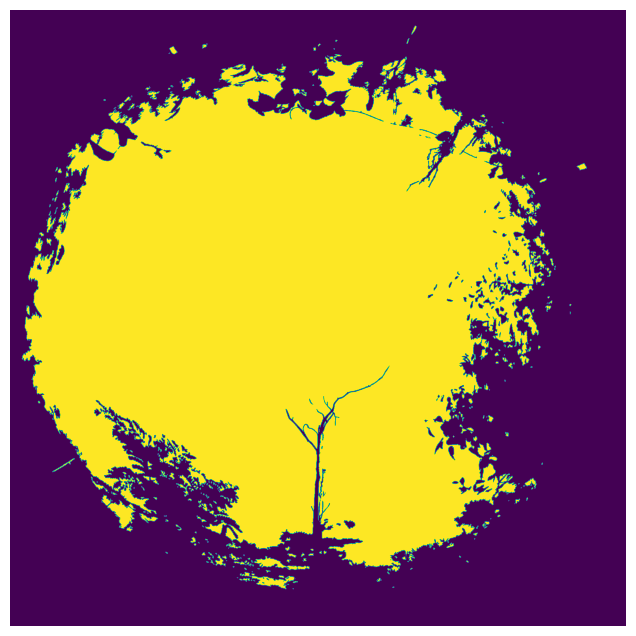

In [69]:
fig = plt.figure("Quickshift segmentation", figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(gray)
plt.axis("off")
plt.savefig(f'{image_name}_cl.png', dpi=300)

In [80]:
image = "R0012437.JPG"
image_name = image.split('.')[0] + "_area.png"

x4 = create_hemispherical(image)

# image_name = image.split('.')[0]
# im.save(image_name + "_bi.png")

In [3]:
image = "R0012437.JPG"
image_name = image.split('.')[0] + "_area.png"

In [43]:
xth = 0.7 * 255

r_ratio = 1
g_ratio = 1
b_ratio = 1

img = cv2.imread(image_name)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [44]:
x = gray
x[x >= xth] = 255
x[x < xth] = 0


im = Image.fromarray(x.astype(np.uint8))

(-0.5, 2686.5, 2686.5, -0.5)

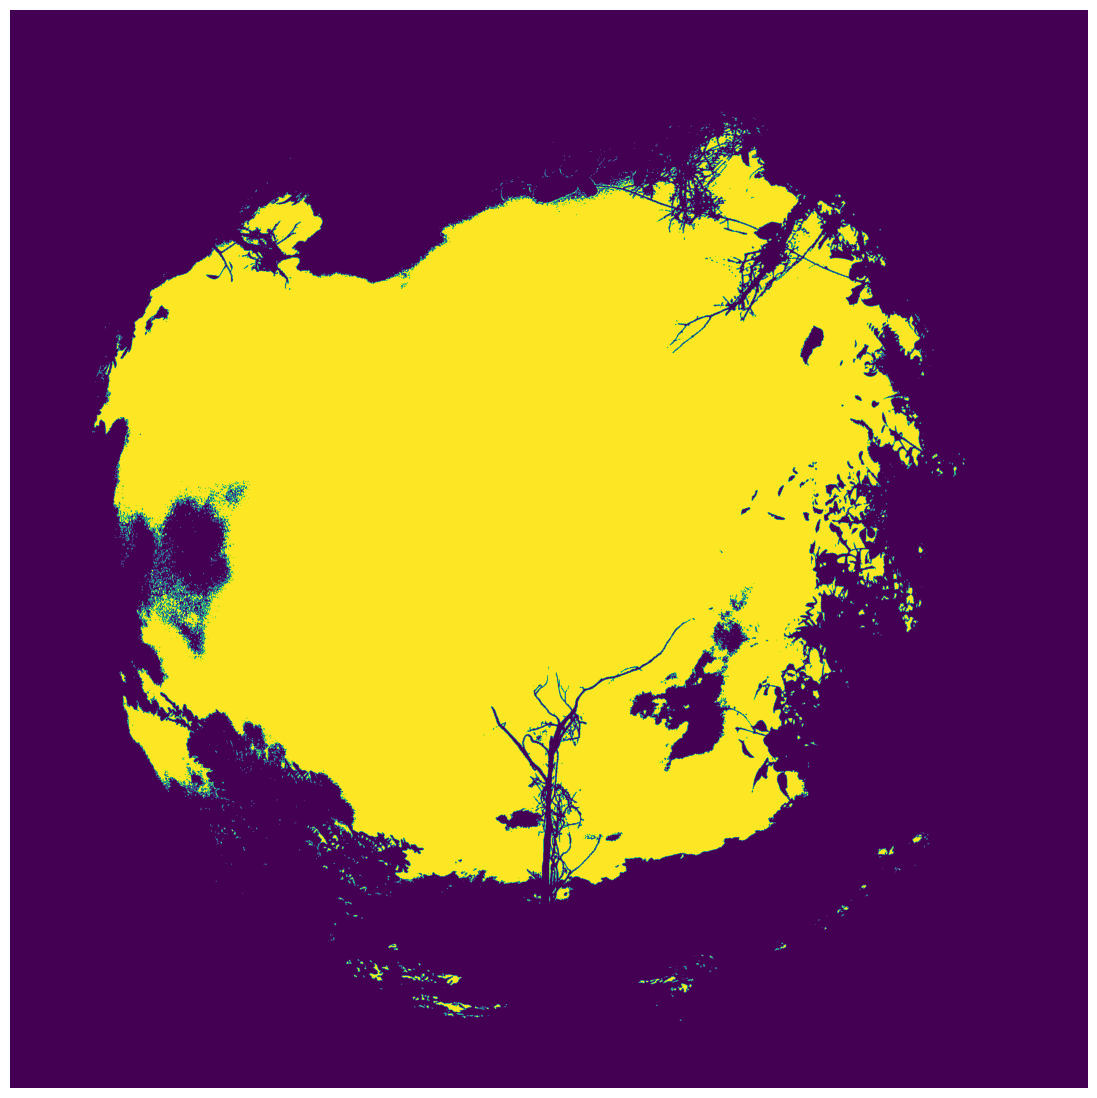

In [45]:
fig = plt.figure("Quickshift segmentation", figsize=(14,14))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(im)
plt.axis("off")

array([0., 1.])

In [65]:
# a simple and hacky way to calculate svf:
# count number of 1 / (numuber of 0 - square area - 0 area)
total_pixels = img.shape[0]*img.shape[0]
hemisphere_pixels = pi * ((img.shape[0]/2) ** 2)
outside_pixels = total_pixels - hemisphere_pixels

black_pixels = total_pixels - np.sum(x/255) - outside_pixels  
svf = (hemisphere_pixels - black_pixels)/hemisphere_pixels
svf

0.44216554417123644